In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(128), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 32

In [3]:
train_dataset = datasets.ImageFolder('../data/train_medium_aug_2/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [4]:
val_dataset = datasets.ImageFolder('../data/val_medium_aug_2/', transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

classes = ('footway', 'primary')

In [7]:
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #optimizer.cleargrads()

    return loss
  return train_step

In [6]:
from torchvision import datasets, models, transforms
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet18(pretrained=True)

#freeze all params
for params in model.parameters():
  params.requires_grad_ = False

#add a new final layer
nr_filters = model.fc.in_features  #number of input features of last layer
model.fc = nn.Linear(nr_filters, 1)

model = model.to(device)

c:\Users\Sebastian Cavada\anaconda3\envs\cv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Sebastian Cavada\anaconda3\envs\cv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Sebastian Cavada/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [8]:
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

#loss
loss_fn = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model

#optimizer
optimizer = torch.optim.Adam(model.fc.parameters()) 

#train step
train_step = make_train_step(model, optimizer, loss_fn)

In [9]:
from tqdm import tqdm


losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = 10
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
  epoch_loss = 0
  for i ,data in tqdm(enumerate(train_loader), total = len(train_loader)): #iterate ove batches
    x_batch , y_batch = data
    x_batch = x_batch.to(device) #move to gpu
    y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
    y_batch = y_batch.to(device) #move to gpu


    loss = train_step(x_batch, y_batch)
    epoch_loss += loss/len(train_loader)
    losses.append(loss)
    
  epoch_train_losses.append(epoch_loss)
  print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

  #validation doesnt requires gradient
  with torch.no_grad():
    cum_loss = 0
    for x_batch, y_batch in val_loader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to(device)

      #model to eval mode
      model.eval()

      yhat = model(x_batch)
      val_loss = loss_fn(yhat,y_batch)
      cum_loss += loss/len(val_loader)
      val_losses.append(val_loss.item())


    epoch_test_losses.append(cum_loss)
    print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))  
    
    best_loss = min(epoch_test_losses)
    
    #save best model
    if cum_loss <= best_loss:
      best_model_wts = model.state_dict()
    
    #early stopping
    early_stopping_counter = 0
    if cum_loss > best_loss:
      early_stopping_counter +=1

    if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
      print("/nTerminating: early stopping")
      break #terminate training
    
#load best model
model.load_state_dict(best_model_wts)

100%|██████████| 63/63 [00:10<00:00,  5.74it/s]



Epoch : 1, train loss : 0.4796164333820343
Epoch : 1, val loss : 0.22687126696109772


100%|██████████| 63/63 [00:04<00:00, 15.06it/s]



Epoch : 2, train loss : 0.35154107213020325
Epoch : 2, val loss : 0.2219245284795761


100%|██████████| 63/63 [00:04<00:00, 14.85it/s]



Epoch : 3, train loss : 0.2955884039402008
Epoch : 3, val loss : 0.23566436767578125


100%|██████████| 63/63 [00:04<00:00, 15.06it/s]



Epoch : 4, train loss : 0.25798317790031433
Epoch : 4, val loss : 0.2719275653362274


100%|██████████| 63/63 [00:04<00:00, 14.75it/s]



Epoch : 5, train loss : 0.24847322702407837
Epoch : 5, val loss : 0.2893085181713104


100%|██████████| 63/63 [00:04<00:00, 15.03it/s]



Epoch : 6, train loss : 0.2307719737291336
Epoch : 6, val loss : 0.09019879251718521


100%|██████████| 63/63 [00:04<00:00, 15.11it/s]



Epoch : 7, train loss : 0.21592193841934204
Epoch : 7, val loss : 0.27276846766471863


100%|██████████| 63/63 [00:04<00:00, 15.03it/s]



Epoch : 8, train loss : 0.20499834418296814
Epoch : 8, val loss : 0.2969355285167694


100%|██████████| 63/63 [00:04<00:00, 14.71it/s]



Epoch : 9, train loss : 0.1978527456521988
Epoch : 9, val loss : 0.2946963906288147


100%|██████████| 63/63 [00:04<00:00, 14.99it/s]



Epoch : 10, train loss : 0.18329323828220367
Epoch : 10, val loss : 0.12626323103904724


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction : Footway


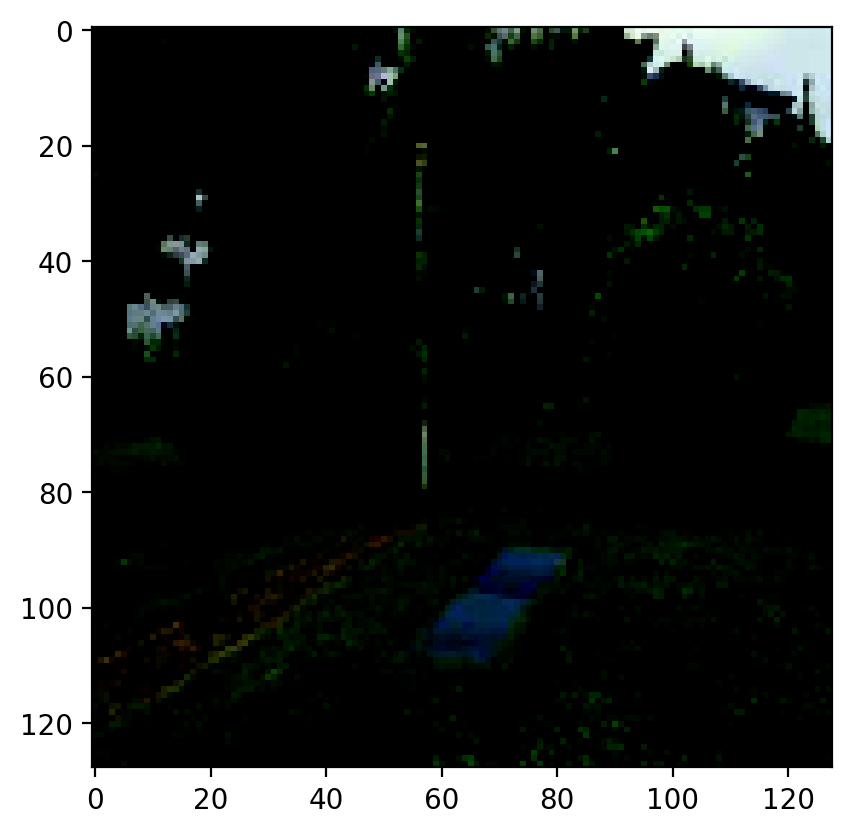

In [35]:
import matplotlib.pyplot as plt 

def inference(test_data):
  idx = torch.randint(1, len(test_data), (1,))
  
  sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)

  if torch.sigmoid(model(sample)) < 0.5:
    print("Prediction : Footway")
  else:
    print("Prediction : Primary")

  plt.imshow(val_dataset[int(idx)][0].permute(1,2,0))

inference(val_dataset)

In [54]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # 3 input image channel, 6 output channels, 5x5 square convolution

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))             
        x = self.fc3(x)
        return x

net = Net()

In [56]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.NAdam(net.parameters(), lr=0.001)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [57]:
loss_values = []
type(loss_values)

accuracy = []
type(accuracy)

loss_values.append(1)
accuracy.append(1)

In [58]:
def double_check_accuracy():
    
    running_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            
            # calculate outputs by running images through the network            
            outputs = net(images)            
            loss = criterion(outputs, labels)

            # print statistics
            running_loss += loss.item() 
            
    accuracy.append(running_loss / len(val_loader))
    print(f'Loss on the validation set { running_loss / len(val_loader) }')

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    print(len(train_loader))
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()        
        if i % 20 == 19:    # print every 2000 mini-batches            
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

    loss_values.append(running_loss / 20)
    double_check_accuracy()    

print('Finished Training')

63
[1,    20] loss: 0.693
[1,    40] loss: 0.692
[1,    60] loss: 0.692
Loss on the validation set 0.6902699023485184
63
[2,    20] loss: 0.690
[2,    40] loss: 0.688
[2,    60] loss: 0.687
Loss on the validation set 0.6849028579890728
63


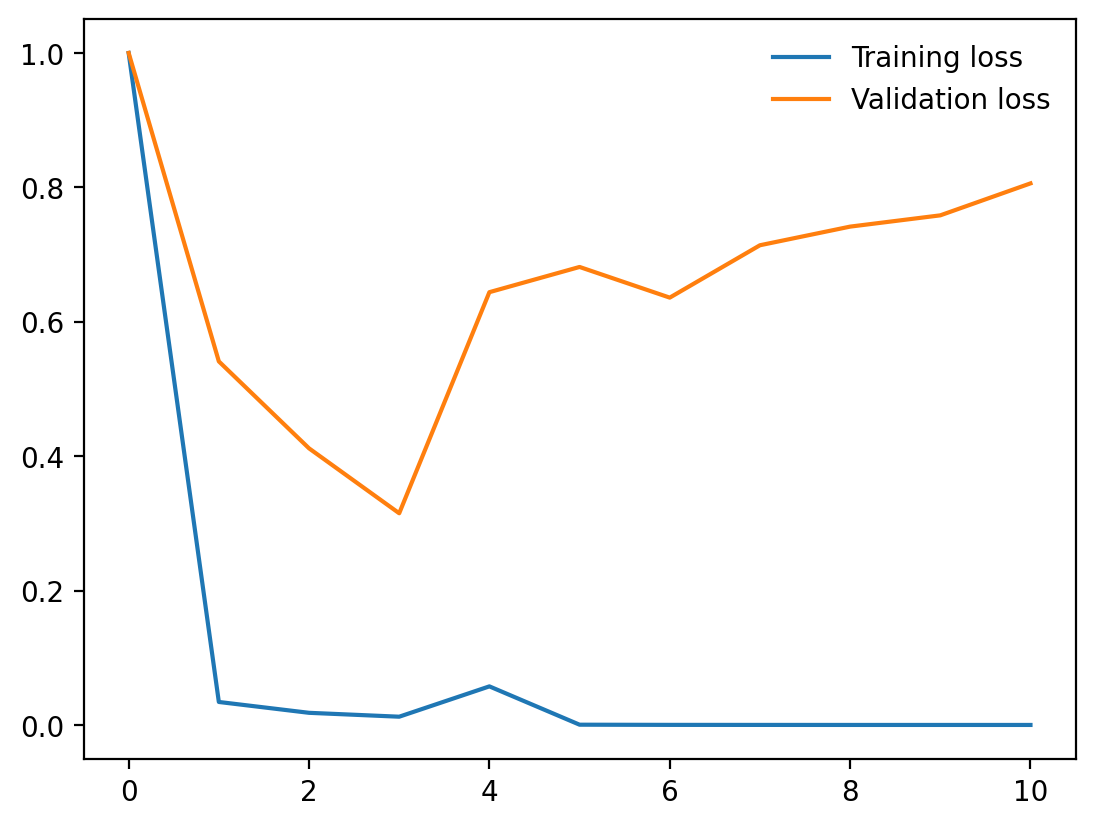

In [49]:
# plot the loss and accuracy and the validation loss and accuracy
plt.plot(loss_values, label='Training loss')
plt.plot(accuracy, label='Validation loss')
plt.legend(frameon=False)

plt.show()

In [27]:
PATH = './test_5.pth'
torch.save(net.state_dict(), PATH)

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    print("a", img.shape)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [29]:
print(len(val_loader))

4


In [31]:
dataiter = iter(val_loader)

for x in next(dataiter):
    images, labels = x
    print(images.shape)
    imshow(torchvision.utils.make_grid(images))
    break

images, labels = next(dataiter)

print(len(dataiter))

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

ValueError: too many values to unpack (expected 2)

In [32]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [33]:
outputs = net(images)

NameError: name 'images' is not defined

In [34]:
_, predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

NameError: name 'images' is not defined

In [35]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    count = 0
    for data in val_loader:        
        count += 1        
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 81 %


In [36]:
issues_dataset = datasets.ImageFolder('./issues_medium/', transform=transform)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './issues_medium/'

In [37]:
train_loader = torch.utils.data.DataLoader(issues_dataset, batch_size=batch_size, shuffle=True)

dataiter = iter(train_loader)
images, labels = next(dataiter)

outputs = net(images)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

NameError: name 'issues_dataset' is not defined